# Implement Jarvis' and Graham's algorithm for finding convex hull and compare them on different sets.

## Tool provided by lecturer as a part of course

In [24]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import timeit
import time

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [25]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Generate points

## (a)

In [26]:
def genA(count, low, high):
    return np.random.uniform(low=low, high=high, size=(count, 2))

## (b)

In [27]:
def genB(count, sx, sy, r):
    a = np.random.uniform(low=0, high=2*np.pi, size=(count, 1))
    x = r * np.cos(a)
    y = r * np.sin(a)
    x += sx
    y += sy
    return np.concatenate((x, y), axis=1)

## (c)

In [28]:
def genC(count, x1, y1, x2, y2, x3, y3, x4, y4):
    v12x, v12y = x2-x1, y2-y1
    v23x, v23y = x3-x2, y3-y2
    v34x, v34y = x4-x3, y4-y3
    v41x, v41y = x1-x4, y1-y4
    
    l12 = np.sqrt(v12x**2 + v12y**2)
    l23 = np.sqrt(v23x**2 + v23y**2)
    l34 = np.sqrt(v34x**2 + v34y**2)
    l41 = np.sqrt(v41x**2 + v41y**2)
    tl = l12 + l23 + l34 + l41
    
    a12 = np.random.uniform(low=0, high=1, size=(int(l12/tl*count), 1))
    a23 = np.random.uniform(low=0, high=1, size=(int(l23/tl*count), 1))
    a34 = np.random.uniform(low=0, high=1, size=(int(l34/tl*count), 1))
    a41 = np.random.uniform(low=0, high=1, size=(int(l41/tl*count), 1))
    
    p12 = np.concatenate((a12*v12x, a12*v12y), axis=1)
    p23 = np.concatenate((a23*v23x, a23*v23y), axis=1)
    p34 = np.concatenate((a34*v34x, a34*v34y), axis=1)
    p41 = np.concatenate((a41*v41x, a41*v41y), axis=1)
    
    p12 += np.array([x1, y1])
    p23 += np.array([x2, y2])
    p34 += np.array([x3, y3])
    p41 += np.array([x4, y4])
    
    return np.concatenate((p12, p23, p34, p41))

## (d)

In [29]:
#square
#   
#   ^
#   |
#   |
#   y-------
#   |       |
#   |       |
# (0,0)-----x----->

def genD(count_axis, count_diag, x, y):
    d1x, d1y = x, y
    d2x, d2y = x, -y
    
    s = [[0,0], [0,y], [x,y], [x,0]]
    
    a1 = np.random.uniform(low=0, high=1, size=(int(count_axis), 1))
    a2 = np.random.uniform(low=0, high=1, size=(int(count_axis), 1))
    d1 = np.random.uniform(low=0, high=1, size=(int(count_diag), 1))
    d2 = np.random.uniform(low=0, high=1, size=(int(count_diag), 1))
    
    pd1 = np.concatenate((a1*d1x, a1*d1y), axis=1)
    pd2 = np.concatenate((a2*d2x, a2*d2y), axis=1)
    pa1 = np.concatenate((d1*0, d1*y), axis=1)
    pa2 = np.concatenate((d2*x, d2*0), axis=1)
    
    pd2 += np.array([0, y])
    
    return np.concatenate((s, pd1, pd2, pa1, pa2))

## Points

### Generate

In [30]:
points = []
points.append(("a", genA(100, -100, 100)))
points.append(("b", genB(100, 0, 0, 10)))
points.append(("c", genC(100, -10, 10, -10, -10, 10, -10, 10, 10)))
points.append(("d", genD(25, 20, 10, 10)))

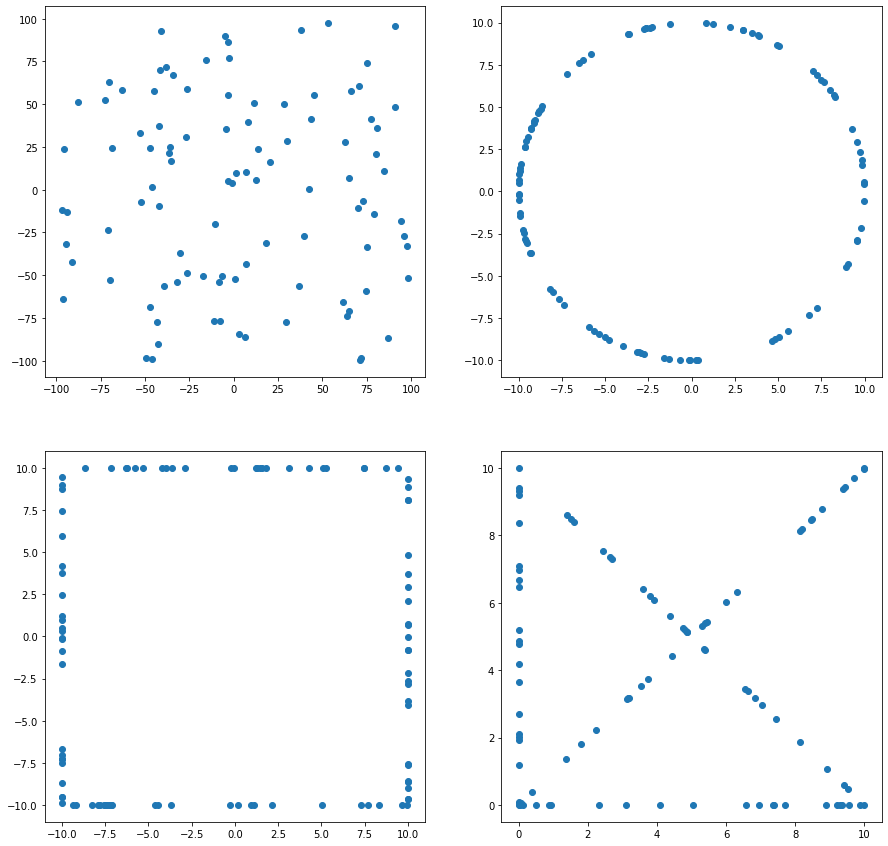

In [31]:
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(15,15))
for i in range(4):
    t, p = points[i]
    
    axes[int(i/2)][i%2].scatter(p[:,0], p[:,1])
    
plt.savefig('points')

# Algorithms

In [32]:
def det3(a, b, c, e):
    r = a[0]*b[1] + b[0]*c[1] + c[0]*a[1] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]
    if r > e:
        return 1
    elif r < -e:
        return -1
    else:
        return 0
    
def dist2(p1, p2):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 

In [33]:
def save_result(data, file):
    np.savetxt(file, data)

### Grahama

In [34]:
def sort_angle(points):
    cos = lambda p: np.dot(p-p0, [1, 0])/np.linalg.norm(p-p0)
    
    #sort by y i x
    points.view('f8,f8').sort(axis=0, order=['f1','f0'])
    p0 = points[0]
    
    #sort by angle
    points = sorted(points[1:].tolist(), key=cos, reverse=True)
    
    ps = []
    #delete duplicates
    for i in range(len(points)-1):
        if cos(points[i]) != cos(points[i+1]):
            ps.append(points[i])
            
    ps.append(points[len(points)-1])
    return p0, ps

def graham(points, e=1e-13):
    p0,points = sort_angle(points)
    
    s = []
    s.append(p0)
    
    for p in points: 
        while len(s) > 1 and (det3(s[-2], s[-1], p, e) < 0 or (det3(s[-2], s[-1], p, e) == 0 and dist2(s[-2], p) > dist(s[-2], s[-1]))):
                s.pop()
        s.append(p)

    s = np.array(s)
    s = np.concatenate((s, [s[0,:]]))
    return s

def graham_scenes(points, e=1e-13):
    sps = PointsCollection(list(map(tuple, points)), color='blue')
    p0,points = sort_angle(points)
    
    scenes = []
    hull = []
    hull_lines = []
    sp0 = PointsCollection([p0], color='red')
    
    s = []
    s.append(p0)
    
    hull.append((p0[0], p0[1]))
    
    scenes.append(Scene([sps, sp0], []))
    
    for p in points:
        while len(s) > 1 and (det3(s[-2], s[-1], p, e) < 0 or (det3(s[-2], s[-1], p, e) == 0 and dist2(s[-2], p) > dist(s[-2], s[-1]))):
            if len(hull_lines) > 0:
                scenes.append(Scene([sps, sp0, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black'), LinesCollection([[(s[-1][0], s[-1][1]), (p[0], p[1])], [(s[-2][0], s[-2][1]), (s[-1][0], s[-1][1])]], color='green'), LinesCollection([[(s[-2][0], s[-2][1]), (p[0], p[1])]], color='red')]))
            s.pop()
            hull.pop()
            hull_lines.pop()
                
        hull_lines.append([(s[-1][0], s[-1][1]), (p[0], p[1])])
        s.append(p)
        hull.append((p[0], p[1]))
        
        scenes.append(Scene([sps, sp0, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black')]))
        
    hull_lines.append([(hull[-1][0], hull[-1][1]), (hull[0][0], hull[0][1])])
    scenes.append(Scene([sps, sp0, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black')]))
   
    return scenes

### Jarvisa

In [116]:
def same_points(p1, p2):
    return p1[0] == p2[0] and p1[1] == p2[1]

def jarvis(points, e=1e-13):
    s = sorted(points, key=lambda p: (p[0], p[1]))
    
    poh_i = 0
    used = [False]*len(s)
    
    pointOnHull = s[0]
    p = []
    
    i = 0
    while True:
        p.append(pointOnHull)
        used[poh_i] = True
        
        first = 0
        while not used[first]:
            first += 1
            
        endpoint = s[first]
        for j in range(first, len(s)):
            if used[j]:
                continue
            
            if same_points(endpoint, pointOnHull) or \
                (det3(p[i], endpoint, s[j], e) > 0):
                first = j
                endpoint = s[j]
                poh_i = j
            elif (det3(p[i], endpoint, s[j], e) == 0 and dist2(p[i], endpoint) < dist2(p[i], s[j])):
                used[first] = True
                first = j
                endpoint = s[j]
                poh_i = j
                
        i += 1
        pointOnHull = endpoint
        
        if same_points(endpoint, p[0]):
            p.append(endpoint)
            return np.array(p)
        
        
def jarvis_scenes(points, e=1e-13):
    scenes = []
    hull = []
    hull_lines = []
    
    s = sorted(points, key=lambda p: (p[0], p[1]))
    
    poh_i = 0
    used = [False]*len(s)
    
    sps = PointsCollection(list(map(tuple, s)), color='blue')
    
    pointOnHull = s[0]
    p = []
    
    i = 0
    while True:
        if len(p) > 0:
            hull_lines.append([(p[-1][0], p[-1][1]), (pointOnHull[0], pointOnHull[1])])
        
        used[poh_i] = True
        p.append(pointOnHull)
        hull.append((pointOnHull[0], pointOnHull[1]))
        scenes.append(Scene([sps, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black')]))  
        
        first = 0
        while not used[first]:
            first += 1
        endpoint = s[first]
        for j in range(len(s)):
            if used[j]:
                continue
            
            if same_points(endpoint, pointOnHull) or (det3(p[i], endpoint, s[j], e) > 0):
                frst = j
                endpoint = s[j]
                poh_i = j
                scenes.append(Scene([sps, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black'), LinesCollection([[(p[i][0], p[i][1]), (s[j][0], s[j][1])]], color='red')]))
            elif (det3(p[i], endpoint, s[j], e) == 0 and dist2(p[i], endpoint) < dist2(p[i], s[j])):
                used[first] = True
                frst = j
                endpoint = s[j]
                poh_i = j
            
        i += 1
        pointOnHull = endpoint
        
        if same_points(endpoint, p[0]):
            hull_lines.append([(hull[-1][0], hull[-1][1]), (hull[0][0], hull[0][1])])
            scenes.append(Scene([sps, PointsCollection(hull.copy(), color='red')], lines=[LinesCollection(hull_lines.copy(), color='black')]))
            return scenes

### Steps of algorithms

In [83]:
%matplotlib notebook

#### Graham

In [ ]:
data = graham_scenes(points[0][1])
plot = Plot(scenes=data)
plot.draw()

In [ ]:
data = graham_scenes(points[1][1])
plot = Plot(scenes=data)
plot.draw()

In [22]:
data = graham_scenes(points[2][1])
plot = Plot(scenes=data)
plot.draw()

<IPython.core.display.Javascript object>

In [ ]:
data = graham_scenes(points[3][1])
plot = Plot(scenes=data)
plot.draw()

#### Jarvis

In [121]:
data = jarvis_scenes(points[0][1])
plot = Plot(scenes=data)
plot.draw()

<IPython.core.display.Javascript object>

In [ ]:
data = jarvis_scenes(points[1][1])
plot = Plot(scenes=data)
plot.draw()

<IPython.core.display.Javascript object>


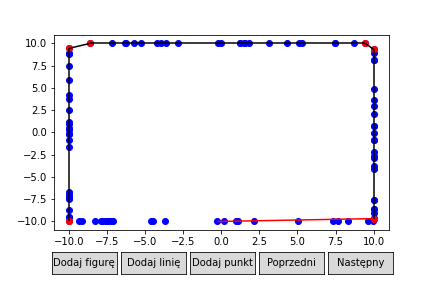

In [124]:
data = jarvis_scenes(points[2][1])
plot = Plot(scenes=data)
plot.draw()

<IPython.core.display.Javascript object>


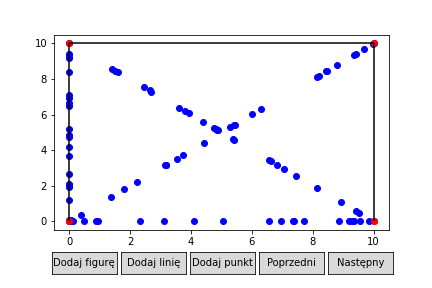

In [123]:
data = jarvis_scenes(points[3][1])
plot = Plot(scenes=data)
plot.draw()

### Check results

In [57]:
%matplotlib inline
def plot(hull, points, file, line=False):
    plt.scatter(points[:,0], points[:,1], c='b', s=1)
    if line:
        plt.plot(hull[:,0], hull[:,1], c='r')
    else:
        plt.scatter(hull[:,0], hull[:,1], c='r', s=3)
    plt.savefig(file)
    plt.clf()

In [58]:
for t,p in points:
    g = graham(p)
    j = jarvis(p)
    
    save_result(g, "graham_" + t)
    save_result(j, "jarvis_" + t)
    
    plot(g, p, 'graham_' + t, True)
    plot(j, p, 'jarvis_' + t, True)
    
    print("Punkty (" + t + ")")
    print("Hull size (Graham): ", len(g))   
    print("Hull size (Jarvis): ", len(j))

Punkty (a)
Liczba punktów (Graham):  14
Liczba punktów (Jarvis):  14
Punkty (b)
Liczba punktów (Graham):  101
Liczba punktów (Jarvis):  101
Punkty (c)
Liczba punktów (Graham):  9
Liczba punktów (Jarvis):  9
Punkty (d)
Liczba punktów (Graham):  5
Liczba punktów (Jarvis):  5


<Figure size 432x288 with 0 Axes>

### Benchmark

In [59]:
from itertools import product 

#converts dict of:
#    key -> list of values 
#    to:
#    list of key -> value
#
#{"p1": [1, 2, 3], "p2": [-1, -2, -3]} -> [{"p1": 1, "p2": -1},{"p1": 2, "p2": -2} ,{"p1": 3, "p2": -3}]
def convert_params(options):
    items = sorted(options.items())
    if not items:
        yield {}
    else:
        keys, values = zip(*items)
        #for v in product(*values):
        #    params = dict(zip(keys, v))
        #    yield params
        if not values:
            yield {}
        else:
            for j in range(len(values[0])):
                v = []
                for i in range(len(keys)):
                    v.append(values[i][j])
                yield dict(zip(keys, v))
                
def bench(func, *args, **kwargs):
    start_time = timeit.default_timer()
    res = func(*args, **kwargs)
    time = timeit.default_timer() - start_time
    return (res, time)

#bench and error detection
def test(title, points, func, **kwargs):
    h1, t1 = bench(func, points, **kwargs)
    print(title, " -> time=", t1, " size=", len(h1))
    return (t1, h1)

#benchmark func on points contained in parr (array of tuple (points, params))
def bench_test(title, parr, func, **kwargs):
    res = []
    for p,params in parr:
        print(params)
        t,h = test(title, p, func, **kwargs)
        res.append((t, h, params))
    
    return res

#generate points based on options
def gen_parr(gen, options):
    parr = []
    for params in convert_params(options):
        parr.append((gen(**params), params))
    return parr

#### (a)

In [118]:
#test cases
options = {"count": [ 10**3,   5*10**3,   10*10**3,   15*10**3,   20*10**3,   25*10**3,   30*10**3,    35*10**3,    40*10**3],
           "low":   [-10**4, -25*10**4, -100*10**4, -225*10**4, -400*10**4, -625*10**4, -900*10**4, -1225*10**4, -1600*10**4],
           "high":  [ 10**4,  25*10**4,  100*10**4,  225*10**4,  400*10**4,  625*10**4,  900*10**4,  1225*10**4,  1600*10**4]}


a_parr = gen_parr(genA, options)

ag_res = bench_test("Graham (a)", a_parr, graham)
aj_res = bench_test("Jarvis (a)", a_parr, jarvis)

{'count': 1000, 'high': 10000, 'low': -10000}
Graham (a)  -> time= 0.07142190000013215  size= 22
{'count': 5000, 'high': 250000, 'low': -250000}
Graham (a)  -> time= 0.31612110000060056  size= 21
{'count': 10000, 'high': 1000000, 'low': -1000000}
Graham (a)  -> time= 0.6223461000008683  size= 26
{'count': 15000, 'high': 2250000, 'low': -2250000}
Graham (a)  -> time= 1.028163900002255  size= 26
{'count': 20000, 'high': 4000000, 'low': -4000000}
Graham (a)  -> time= 1.307963600000221  size= 29
{'count': 25000, 'high': 6250000, 'low': -6250000}
Graham (a)  -> time= 1.7936190000000352  size= 18
{'count': 30000, 'high': 9000000, 'low': -9000000}
Graham (a)  -> time= 1.9328992000009748  size= 27
{'count': 35000, 'high': 12250000, 'low': -12250000}
Graham (a)  -> time= 2.1860090000009222  size= 27
{'count': 40000, 'high': 16000000, 'low': -16000000}
Graham (a)  -> time= 2.457893500002683  size= 29
{'count': 1000, 'high': 10000, 'low': -10000}
Jarvis (a)  -> time= 0.23135049999837065  size= 22

#### (b)

In [119]:
options = {"count": [ 10**2,   5*10**2,   10*10**2,   15*10**2,   20*10**2,   25*10**2,   30*10**2,    35*10**2,    40*10**2],
           "sx":    [     0,         0,          0,          0,          0,          0,          0,           0,           0],
           "sy":    [     0,         0,          0,          0,          0,          0,          0,           0,           0],
           "r":     [ 10**2,   2*10**2,    3*10**2,    4*10**2,    4*10**2,    5*10**2,    5*10**2,     6*10**2,     6*10**2]}

b_parr = gen_parr(genB, options)
bg_res = bench_test("Graham (b)", b_parr, graham)
bj_res = bench_test("Jarvis (b)", b_parr, jarvis)

{'count': 100, 'r': 100, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.01055379999888828  size= 101
{'count': 500, 'r': 200, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.0349320000022999  size= 501
{'count': 1000, 'r': 300, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.08288109999921289  size= 1001
{'count': 1500, 'r': 400, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.09608880000087083  size= 1501
{'count': 2000, 'r': 400, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.13866480000069714  size= 2001
{'count': 2500, 'r': 500, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.16310090000115451  size= 2501
{'count': 3000, 'r': 500, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.1850799999992887  size= 3001
{'count': 3500, 'r': 600, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.2702069999977539  size= 3501
{'count': 4000, 'r': 600, 'sx': 0, 'sy': 0}
Graham (b)  -> time= 0.2801017000019783  size= 4001
{'count': 100, 'r': 100, 'sx': 0, 'sy': 0}
Jarvis (b)  -> time= 0.04029609999997774  size= 101
{'count': 500, 'r': 200, 'sx': 0, 'sy': 

#### (c)

In [127]:
options = {"count": [   10**3,   5*10**3,  10*10**3,  15*10**3,  20*10**3,   25*10**3,   30*10**3,   35*10**3,   40*10**3],
           "x1":    [ 4*10**2,  20*10**2,  40*10**2,  60*10**2,  80*10**2,  100*10**2,  120*10**2,  140*10**2,  160*10**2],
           "y1":    [ 4*10**2,  20*10**2,  40*10**2,  60*10**2,  80*10**2,  100*10**2,  120*10**2,  140*10**2,  160*10**2],
           "x2":    [ 4*10**2,  20*10**2,  40*10**2,  60*10**2,  80*10**2,  100*10**2,  120*10**2,  140*10**2,  160*10**2],
           "y2":    [-4*10**2, -20*10**2, -40*10**2, -60*10**2, -80*10**2, -100*10**2, -120*10**2, -140*10**2, -160*10**2],
           "x3":    [-4*10**2, -20*10**2, -40*10**2, -60*10**2, -80*10**2, -100*10**2, -120*10**2, -140*10**2, -160*10**2],
           "y3":    [-4*10**2, -20*10**2, -40*10**2, -60*10**2, -80*10**2, -100*10**2, -120*10**2, -140*10**2, -160*10**2],
           "x4":    [ 4*10**2, -20*10**2, -40*10**2, -60*10**2, -80*10**2, -100*10**2, -120*10**2, -140*10**2, -160*10**2],
           "y4":    [ 4*10**2,  20*10**2,  40*10**2,  60*10**2,  80*10**2,  100*10**2,  120*10**2,  140*10**2,  160*10**2]}

c_parr = gen_parr(genC, options)
cg_res = bench_test("Graham (c)", c_parr, graham, e=1e-6)
cj_res = bench_test("Jarvis (c)", c_parr, jarvis, e=1e-6)

{'count': 1000, 'x1': 400, 'x2': 400, 'x3': -400, 'x4': 400, 'y1': 400, 'y2': -400, 'y3': -400, 'y4': 400}
Graham (c)  -> time= 0.06894540000212146  size= 7
{'count': 5000, 'x1': 2000, 'x2': 2000, 'x3': -2000, 'x4': -2000, 'y1': 2000, 'y2': -2000, 'y3': -2000, 'y4': 2000}
Graham (c)  -> time= 0.345184199999494  size= 9
{'count': 10000, 'x1': 4000, 'x2': 4000, 'x3': -4000, 'x4': -4000, 'y1': 4000, 'y2': -4000, 'y3': -4000, 'y4': 4000}
Graham (c)  -> time= 0.6685217999984161  size= 9
{'count': 15000, 'x1': 6000, 'x2': 6000, 'x3': -6000, 'x4': -6000, 'y1': 6000, 'y2': -6000, 'y3': -6000, 'y4': 6000}
Graham (c)  -> time= 1.088253200003237  size= 9
{'count': 20000, 'x1': 8000, 'x2': 8000, 'x3': -8000, 'x4': -8000, 'y1': 8000, 'y2': -8000, 'y3': -8000, 'y4': 8000}
Graham (c)  -> time= 1.3983482000003278  size= 9
{'count': 25000, 'x1': 10000, 'x2': 10000, 'x3': -10000, 'x4': -10000, 'y1': 10000, 'y2': -10000, 'y3': -10000, 'y4': 10000}
Graham (c)  -> time= 1.6837709999999788  size= 9
{'count'

#### (d)

In [128]:
options = {"count_diag": [25*10**2, 125*10**2, 250*10**2, 375*10**2, 500*10**2, 625*10**2, 750*10**2, 875*10**2, 1000*10**2],
           "count_axis": [25*10**2, 125*10**2, 250*10**2, 375*10**2, 500*10**2, 625*10**2, 750*10**2, 875*10**2, 1000*10**2],
           "x":          [ 4*10**3,  20*10**3,  40*10**3,  60*10**3,  80*10**3, 100*10**3, 120*10**3, 140*10**3,  160*10**3],
           "y":          [ 4*10**3,  20*10**3,  40*10**3,  60*10**3,  80*10**3, 100*10**3, 120*10**3, 140*10**3,  160*10**3]}

# dj_options = {"count_diag": [25*10**1, 50*10**1,  75*10**1, 100*10**1, 125*10**1, 150*10**1, 175*10**1, 200*10**1, 225*10**1],
#               "count_axis": [25*10**1, 50*10**1,  75*10**1, 100*10**1, 125*10**1, 150*10**1, 175*10**1, 200*10**1, 225*10**1],
#               "x":          [40*10**2, 80*10**2, 120*10**2, 160*10**2, 200*10**2, 240*10**2, 280*10**2, 320*10**2, 360*10**2],
#               "y":          [40*10**2, 80*10**2, 120*10**2, 160*10**2, 200*10**2, 240*10**2, 280*10**2, 320*10**2, 360*10**2]}

d_parr = gen_parr(genD, options)
dg_res = bench_test("Graham (d)", d_parr, graham)
dj_res = bench_test("Jarvis (d)", d_parr, jarvis)

{'count_axis': 2500, 'count_diag': 2500, 'x': 4000, 'y': 4000}
Graham (d)  -> time= 0.632925099998829  size= 5
{'count_axis': 12500, 'count_diag': 12500, 'x': 20000, 'y': 20000}
Graham (d)  -> time= 3.081393800002843  size= 5
{'count_axis': 25000, 'count_diag': 25000, 'x': 40000, 'y': 40000}
Graham (d)  -> time= 6.167969500002073  size= 5
{'count_axis': 37500, 'count_diag': 37500, 'x': 60000, 'y': 60000}
Graham (d)  -> time= 9.177522600002703  size= 5
{'count_axis': 50000, 'count_diag': 50000, 'x': 80000, 'y': 80000}
Graham (d)  -> time= 12.37536380000165  size= 5
{'count_axis': 62500, 'count_diag': 62500, 'x': 100000, 'y': 100000}
Graham (d)  -> time= 15.35270699999819  size= 5
{'count_axis': 75000, 'count_diag': 75000, 'x': 120000, 'y': 120000}
Graham (d)  -> time= 18.896542800001043  size= 5
{'count_axis': 87500, 'count_diag': 87500, 'x': 140000, 'y': 140000}
Graham (d)  -> time= 21.9582885000018  size= 5
{'count_axis': 100000, 'count_diag': 100000, 'x': 160000, 'y': 160000}
Graham 

### Złożność czasowa

In [129]:
def extract_data_total_graham(x):
    t,h,params = x
    return [params['count'], t]

def extract_data_total_jarvis(x):
    t,h,params = x
    return [params['count'], t]

def extract_data_diag_graham(x):
    t,h,params = x
    return [2*(params['count_diag'] + params['count_axis']), t]

def extract_data_diag_jarvis(x):
    t,h,params = x
    return [2*(params['count_diag'] + params['count_axis']), t]

In [130]:
ag_p = np.array(list(map(extract_data_total_graham, ag_res)))
bg_p = np.array(list(map(extract_data_total_graham, bg_res)))
cg_p = np.array(list(map(extract_data_total_graham, cg_res)))
dg_p = np.array(list(map(extract_data_diag_graham, dg_res)))

aj_p = np.array(list(map(extract_data_total_jarvis, aj_res)))
bj_p = np.array(list(map(extract_data_total_jarvis, bj_res)))
cj_p = np.array(list(map(extract_data_total_jarvis, cj_res)))
dj_p = np.array(list(map(extract_data_diag_jarvis, dj_res)))

In [137]:
def plot_time(titles, graham_data, jarvis_data, file):
    n = len(graham_data)   
    fig, axes = plt.subplots(ncols=1, nrows=n, figsize=(8,15))
    
    if n == 1:
        axes = [axes]
    else:
        axes = axes.reshape(-1)
    
    for t,p1,p2,ax in zip(titles, graham_data, jarvis_data, axes):
        ax.plot(p1[:,0], p1[:,1], '-o', c='r')
        ax.plot(p2[:,0], p2[:,1], '-o', c='b')
        ax.legend(['Graham', 'Jarvis'])
        ax.set_title(t)
        
        #a = p[0][1]/p[0][0]
        #ax.plot([0, p[-1][0]], [0, a*p[-1][0]])
        
        
    plt.savefig(file)

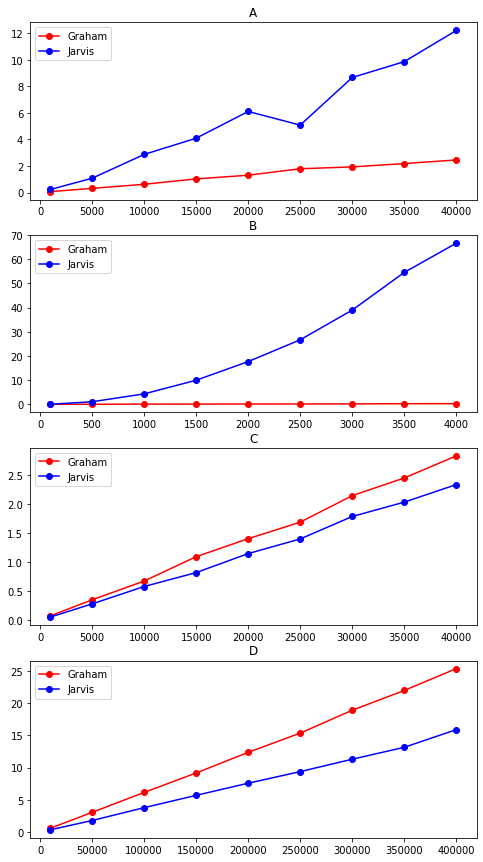

In [138]:
%matplotlib inline
plot_time(['A', 'B', 'C', 'D'], [ag_p, bg_p, cg_p, dg_p], [aj_p, bj_p, cj_p, dj_p], 'times')

In [159]:
def extract_data_total_correction_jarvis(x):
    t,h,params = x
    return [params['count']*(len(h)-1), t]

def extract_data_diag_correction_jarvis(x):
    t,h,params = x
    return [2*(params['count_diag'] + params['count_axis'])*(len(h)-1), t]

def plot_corr_time(titles, jarvis_data, file):
    n = len(jarvis_data)   
    fig, axes = plt.subplots(ncols=1, nrows=n, figsize=(8,15))
    
    if n == 1:
        axes = [axes]
    else:
        axes = axes.reshape(-1)
    
    for t,p1,ax in zip(titles, jarvis_data, axes):
        ax.plot(p1[:,0], p1[:,1], '-o', c='r')
        ax.legend(['Jarvis'])
        ax.set_title(t)
        
    plt.savefig(file)

In [160]:
aj_c_p = np.array(sorted(list(map(extract_data_total_correction_jarvis, aj_res)), key=lambda p: p[0]))
bj_c_p = np.array(sorted(list(map(extract_data_total_correction_jarvis, bj_res)), key=lambda p: p[0]))
cj_c_p = np.array(sorted(list(map(extract_data_total_correction_jarvis, cj_res)), key=lambda p: p[0]))
dj_c_p = np.array(sorted(list(map(extract_data_diag_correction_jarvis, dj_res)), key=lambda p: p[0]))

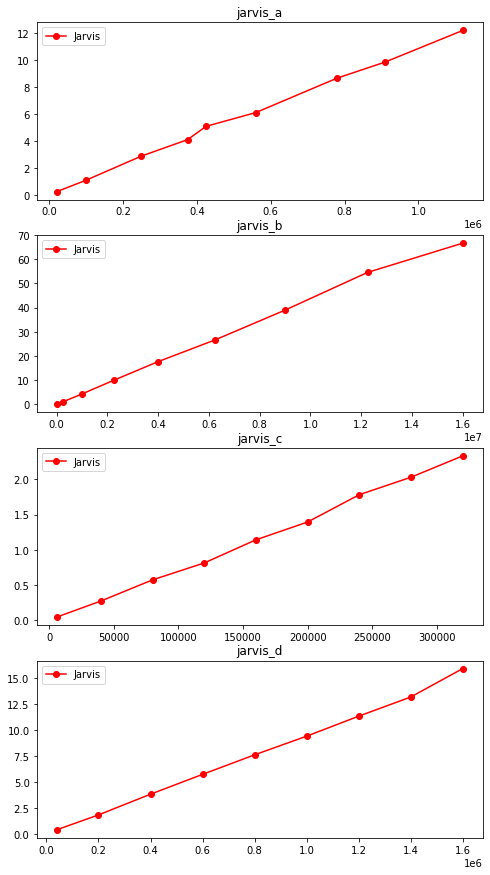

In [161]:
plot_corr_time(['jarvis_a', 'jarvis_b', 'jarvis_c', 'jarvis_d'], [aj_c_p, bj_c_p, cj_c_p, dj_c_p], 'jarvis_correction_time')